In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

In [2]:
N = 16
K = 8
slicer = 2
batch_size = int((2**K)/slicer)

In [3]:
def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    
    return s

def inc_bin(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=int), np.ones(1,dtype=int)))
    a = add_bool(a,increment)
    return a

def approx(C):
    W = inv_fc(1-(1-pi_fc(C))**2)  
    return W

def pi_fc(x):
    a = -0.4527
    b = 0.0218
    r = 0.86
    
    if x < 10:
        P = np.exp(a*(x**r)+b)
    else:
        P = np.sqrt((np.pi)/x)*np.exp(-x/4)*(1-10/(7*x))
        
    return P

def inv_fc(x):
    a = -0.4527
    b = 0.0218
    r = 0.86
    
    I = ((np.log(x)-b)/a)**(1/r)
    
    return I
    

def polarization(N, K, sigma_train):
    
    W = np.ones(N, dtype=float)
    W_temp = np.zeros(N, dtype=float)
    
    W[0] = (2/(sigma_train**2))
    
    for i in range(1, int(np.log2(N))+1):
        W_temp[:] = W[:]
        t = 2**(i-1)
        
        for j in range(1,(int(t))+1):
            C = W_temp[j-1]
            W[2*j-1-1] = approx(C)         #polarization by using density evolution
            W[2*j-1] = 2*C
                  
    qfunc = lambda x: 0.5-0.5*scipy.special.erf(x/np.sqrt(2))
    W = qfunc(np.sqrt(W/2))
    idx = sorted(range(W.size), key=lambda k: -W[k]) # descend order 
    A = idx[-K:]
    
    
    return A
    
def encoding(u, N):

    n = 1
    x = np.copy(u)
    step = np.log2(N)
    for s in range(0,step.astype(int)):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
        
    for s in range(0,N):
        if np.mod(x[s],2) == 0:
            x[s] = 0

    return x

In [4]:
snr_train = 1
sigma_train = np.sqrt(1/(2*10**(snr_train/10)))
print(sigma_train)

0.630209582093


In [5]:
b = np.zeros((2**K,K),dtype=int)
for i in range(1,2**K):
    b[i]= inc_bin(b[i-1])

In [6]:
A = polarization(N, K, sigma_train)
u = np.zeros((2**K, N), dtype=int)
u[:,A] = b

In [7]:
A # index of information bits

[9, 10, 12, 7, 11, 13, 14, 15]

In [8]:
x = np.zeros((2**K, N), dtype=int)

for i in range(0, 2**K):
    x[i,:] = encoding(u[i,:], N)
    
x = (-1)**x # BPSK modulation

In [9]:
b[:,:] #all possible information sequence

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [10]:
x[:,:] #modulated codeword

array([[ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ...,  1, -1,  1],
       ..., 
       [-1, -1,  1, ...,  1, -1, -1],
       [-1,  1,  1, ..., -1, -1,  1],
       [ 1, -1, -1, ...,  1,  1, -1]])

In [13]:
Layer1 = 128
Layer2 = 64
Layer3 = 32
Layer4 = K


X = tf.placeholder(tf.float32,[None, N])
Y = tf.placeholder(tf.float32,[None, K])
#keep_prob = tf.placeholder(tf.float32)

# W1 = tf.Variable(tf.zeros([N, Layer1]))
# W2 = tf.Variable(tf.zeros([Layer1, Layer2]))
# W3 = tf.Variable(tf.zeros([Layer2, Layer3]))
# W4 = tf.Variable(tf.zeros([Layer3, Layer4]))

W1 = tf.Variable(tf.random_uniform([N, Layer1], -1.0, 1.0))
W2 = tf.Variable(tf.random_uniform([Layer1, Layer2], -1.0, 1.0))
W3 = tf.Variable(tf.random_uniform([Layer2, Layer3], -1.0, 1.0))
W4 = tf.Variable(tf.random_uniform([Layer3, Layer4], -1.0, 1.0))
# W5 = tf.Variable(tf.random_uniform([Layer4, Layer5], -1.0, 1.0))
# W6 = tf.Variable(tf.random_uniform([Layer5, Layer6], -1.0, 1.0))

# W1 = tf.get_variable("W1", shape=[N, Layer1], initializer=tf.contrib.layers.xavier_initializer())
# W2 = tf.get_variable("W2", shape=[Layer1, Layer2], initializer=tf.contrib.layers.xavier_initializer())
# W3 = tf.get_variable("W3", shape=[Layer2, Layer3], initializer=tf.contrib.layers.xavier_initializer())
# W4 = tf.get_variable("W4", shape=[Layer3, Layer4], initializer=tf.contrib.layers.xavier_initializer())
# W5 = tf.get_variable("W5", shape=[Layer4, Layer5], initializer=tf.contrib.layers.xavier_initializer())


b1 = tf.Variable(tf.zeros([Layer1]), name = "Bias1")
b2 = tf.Variable(tf.zeros([Layer2]), name = "Bias2")
b3 = tf.Variable(tf.zeros([Layer3]), name = "Bias3")
b4 = tf.Variable(tf.zeros([Layer4]), name = "Bias4")
# b5 = tf.Variable(tf.zeros([Layer5]), name = "Bias5")
# b6 = tf.Variable(tf.zeros([Layer6]), name = "Bias6")

L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
#L1 = tf.nn.dropout(L1, keep_prob = keep_prob)

L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
#L2 = tf.nn.dropout(L2, keep_prob = keep_prob)

L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
#L3 = tf.nn.dropout(L3, keep_prob = keep_prob)

# L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
# #L4 = tf.nn.dropout(L4, keep_prob = keep_prob)

# L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

h1 = tf.nn.sigmoid(tf.matmul(L3, W4) + b4)

h2 = tf.maximum(h1,0.)
hypo = tf.minimum(1., h2)

#cost = -tf.reduce_mean(tf.maximum(Y,0)*tf.log(hypo)+tf.maximum(-Y,0)*tf.log(-hypo)+((1-tf.abs(Y))*tf.log(1-hypo)))
#cost = -tf.reduce_mean(tf.maximum(Y,0)*tf.log(hypo)+tf.maximum(-Y,0)*tf.log(-hypo)+((1-tf.abs(Y))*tf.log(1-hypo)))
#cost = -tf.reduce_mean(Y*tf.log(hypo)+(1-Y)*tf.log(1-hypo))
cost = tf.reduce_mean(tf.square(Y-h1))

a = 0.001
#optimizer = tf.train.GradientDescentOptimizer(a)
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(cost)


In [14]:
## mini batch
init = tf.global_variables_initializer()
sess = tf.Session()



num_train = 4

trial = 2500
num_snr = 4
error = np.zeros([num_train, num_snr], dtype="float")
BER = np.zeros([num_train, num_snr], dtype="float")

for t in range(num_train):
    
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    sess.run(init)
    print("# of training : {}".format(10**((t+3))))
    
    for step in range(slicer*10**((t+3))):
        
        arr = np.arange(2**K)
        np.random.shuffle(arr)
        batch_arr = arr[0:batch_size]
        
        xx = x[batch_arr]+np.random.normal(0,sigma_train,(batch_size, N))#*(2/sigma_train**2)
        bb = b[batch_arr]
        
        sess.run(train, feed_dict={X:xx, Y:bb})
                                 # {X:(x+np.random.normal(0,sigma_train,(2**K, N)))*(2/sigma_train**2), Y:b,keep_prob:1.}
                                 # {X:(x+np.random.normal(0,sigma_train,(2**K, N)))*(2/sigma_train**2), Y:b,keep_prob:1.}

#         if step % 10000 == 0:
#             print("step:", step, 
#                   "cost:", sess.run(cost, feed_dict={X:xx, Y:bb}))
            #print("prediction",sess.run(hypo, feed_dict={X:xx, Y:b}))    
        
        #print(sess.run(accuracy, feed_dict={X:(x+np.random.normal(0,sigma_train,(2**K, N)))*(2/sigma_train**2), Y:b,keep_prob:1.}))
    correct_detection = tf.equal(tf.round(hypo), Y)
    accuracy = tf.reduce_mean(tf.cast(correct_detection,"float"))        

    print("--------training result (w/o noise) --------")
    print("Accuracy:", sess.run(accuracy, feed_dict={X:x, Y:b}),
          "cost:", sess.run(cost, feed_dict={X:x, Y:b}))

    print("--------checking BER (w.r.t various noise)--------")

    
    for snr in range(num_snr):
        
        err = 0
        
        sigma = np.sqrt(1/(2*10**(snr/10)))
        to = 0
    
        for i in range(trial):
            
            #sess.run(hypo, feed_dict={X:x+np.random.normal(0,sigma_train,(2**K, N))*(2/sigma_train**2), Y:b,keep_prob:1.})
            
            wrong_detection = tf.not_equal(tf.round(hypo), Y)
            num_error = tf.reduce_sum(tf.cast(wrong_detection,"float"))     

            e = sess.run(num_error, feed_dict={X:(x+np.random.normal(0,sigma,(2**K, N))), Y:b})
            
            #print(e)
            
            err = e#*(2**K)*N

            to = to + (2**K)*K
            error[t, snr] = error[t, snr] + err

            if error[t, snr]>301:
                break
            
        print("SNR",snr, error[t, snr]/to)

        BER[t, snr] = error[t, snr]/to
        



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# of training : 1000
--------training result (w/o noise) --------
Accuracy: 0.858887 cost: 0.138046
--------checking BER (w.r.t various noise)--------
SNR 0 0.26123046875
SNR 1 0.21923828125
SNR 2 0.1884765625
SNR 3 0.18994140625
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# of training : 10000
--------training result (w/o noise) --------
Accuracy: 0.983398 cost: 0.0165468
--------checking BER (w.r.t various noise)--------
SNR 0 0.09765625
SNR 1 0.0706380208333
SNR 2 0.0487060546875
SNR 3 0.033203125
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# of training : 100000
--------training result (w/o noise) --------
Accuracy: 1.0 cost: 2.87962e-07
--------checking BER (w.r.t various noise)--------
SNR 0 0.0269368489583
SNR 1 0.00936889648438
SNR 2 0.00286395733173
SNR 3 0.000676426318807
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

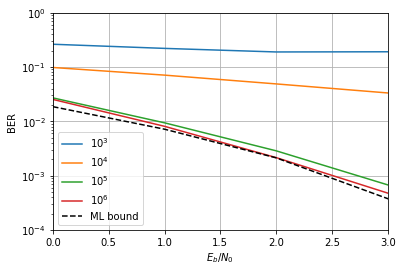

In [15]:
num_train = 4


ML = [0.018563,    0.0071536,    0.0021272,   0.00037756,    4.625e-05] 
    
legend = []

plt.figure(1)

for t in range(num_train):
    plt.plot(range(num_snr), BER[t,0:num_snr])
    legend.append('$10^{{{}}}$'.format(t+3)) 

# plt.plot(range(len(SC)), SC, 'k--')    
# legend.append('SC')
    
plt.plot(range(len(ML)), ML, 'k--')
legend.append('ML bound')
# plt.plot(range(len(SC_ML)), SC_ML)     
# legend.append('SCL_4')

plt.axis([0, num_snr-1, 1e-4, 1])

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()